In [1]:
import pandas as pd
#import modules and test files

train_set = pd.read_csv("./tidy_text_data.csv")
train_set.head()
train_set = train_set[:1288]

In [2]:
import pandas as pd
import spacy
import re
import nltk

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from nltk.corpus import stopwords

In [3]:
# Helper function    
def lemmatize(word_list, ptags):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    spC = spacy.load('en_core_web_sm')
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists

In [4]:
#txt requirements
# pandas
# numpy
# spacy>=2.2.4
# nltk>=3.4.5
# gensim>=3.8.3
# plotnine>=0.6.0
# tomotopy>=0.7.1
# wordcloud>=1.7.0

import numpy as np 
import spacy
import nltk as nltk
import gensim
import plotnine
import tomotopy
import re
# import wordcloud
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
st_words = stopwords.words('english')
extra_stops=['from','subject','re', 'edu','use']
st_words.extend(extra_stops)

In [5]:
doc_list = train_set.text_new.values.tolist()
word_list = [simple_preprocess(str(txt), deacc=True, min_len=3) for txt in doc_list]
bigram = Phrases(word_list, min_count=5, threshold=100) # use original wordlist to build model
bigram_model = Phraser(bigram)
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]
word_list_lemmatized = lemmatize(word_bigrams, ptags=['NOUN','VERB','ADV','ADJ'])
word_list_lemmatized[0][:7]



['lean', 'empty', 'guard', 'desk', 'hear', 'footstep', 'straighten']

In [6]:
list_to_remove = []
for i, word_list in enumerate(word_list_lemmatized):
    if len(word_list) == 0:
        list_to_remove.append(i)
list_to_remove.reverse()
for index in list_to_remove:
    word_list_lemmatized.pop(index)

In [7]:
len(word_list_lemmatized[0])

15

In [8]:
len(word_list_lemmatized)

1285

In [9]:
import tomotopy as tp
term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1,
                  alpha=0.1, initial_k=10, seed=99999)
                  

In [10]:
# for vec in word_list_lemmatized:
#     hdp.add_doc(vec)

# # Initiate sampling burn-in  (i.e. discard N first iterations)
# hdp.burn_in = 100
# hdp.train(0)
# print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
#       ', Num words:', hdp.num_words)
# print('Removed top words:', hdp.removed_top_words)

# # Train model
# for i in range(0, 1000, 100):
#     hdp.train(100) # 100 iterations at a time
#     print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

In [11]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [12]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=1000)
    hdp.save(''.join(['models/hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))
    

Training...


Model one
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.925464187956364	Num. of topics: 136
Iteration: 100	Log-likelihood: -6.9483936138578875	Num. of topics: 250
Iteration: 200	Log-likelihood: -6.941157477131826	Num. of topics: 258
Iteration: 300	Log-likelihood: -6.940881304050746	Num. of topics: 272
Iteration: 400	Log-likelihood: -6.926315340204114	Num. of topics: 263
Iteration: 500	Log-likelihood: -6.940545875986675	Num. of topics: 266
Iteration: 600	Log-likelihood: -6.935203350591349	Num. of topics: 264
Iteration: 700	Log-likelihood: -6.9398210513070095	Num. of topics: 259
Iteration: 800	Log-likelihood: -6.9233175924831	Num. of topics: 261
Iteration: 900	Log-likelihood: -6.935077876804285	Num. of topics: 262

Training...



Done

Model pmi
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -5.334136859594444	Num. of topics: 290
Iteration: 100	Log-likelihood: -4.797313098613259	Num. of topics: 534
Iteration: 200	Log-likelihood: -4.874727824020182	Num. of topics: 508
Iteration: 300	Log-likelihood: -4.951349321749643	Num. of topics: 481
Iteration: 400	Log-likelihood: -5.049963618124162	Num. of topics: 444
Iteration: 500	Log-likelihood: -5.113989482341455	Num. of topics: 436
Iteration: 600	Log-likelihood: -5.196921586489937	Num. of topics: 399
Iteration: 700	Log-likelihood: -5.2202295896102004	Num. of topics: 387
Iteration: 800	Log-likelihood: -5.211026913120367	Num. of topics: 395


Training...


Iteration: 900	Log-likelihood: -5.220869478197614	Num. of topics: 390
Done

Model idf
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.425346400016975	Num. of topics: 46
Iteration: 100	Log-likelihood: -6.320847405699087	Num. of topics: 65
Iteration: 200	Log-likelihood: -6.340844036767572	Num. of topics: 74
Iteration: 300	Log-likelihood: -6.310567974258196	Num. of topics: 73
Iteration: 400	Log-likelihood: -6.328287703814059	Num. of topics: 71
Iteration: 500	Log-likelihood: -6.315492504371608	Num. of topics: 72
Iteration: 600	Log-likelihood: -6.329981561455401	Num. of topics: 70
Iteration: 700	Log-likelihood: -6.288277395510882	Num. of topics: 80
Iteration: 800	Log-likelihood: -6.327782686957737	Num. of topics: 71
Iteration: 900	Log-likelihood: -6.3139962331444135	Num. of topics: 74
Done



In [13]:
hdp_model = tp.HDPModel.load("models/hdp_model_idf.bin")

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(hdp_model)

labeler = tp.label.FoRelevance(hdp_model, cands, min_df=5, smoothing=1e-2, mu=0.7)
for k in range(hdp_model.k):
    
    if not hdp_model.is_live_topic(k): continue
        
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in hdp_model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()
    

== Topic #0 ==
Labels: friend, sure, kill, want, hold
new	0.06568361818790436
friend	0.062097880989313126
pig	0.0489526204764843
embrace	0.0489526204764843
want	0.0481276735663414
heat	0.047347117215394974
produce	0.045989684760570526
manage	0.044813819229602814
receive	0.04377663508057594
star	0.04377663508057594

== Topic #1 ==
Labels: order, stay, house, month, wonder
nice	0.17312823235988617
order	0.15482258796691895
stay	0.14337040483951569
house	0.1284349113702774
month	0.12698611617088318
walk	0.0003115596773568541
find	0.0003115522558800876
mind	0.0003115225408691913
always	0.0003115151193924248
person	0.0003114928549621254

== Topic #2 ==
Labels: discover, make sense, explain, front, huge
wonder	0.09989160299301147
aware	0.05047808215022087
front	0.049968522042036057
huge	0.04417843371629715
discover	0.04417843371629715
include	0.04417843371629715
explain	0.03787877783179283
road	0.03622175753116608
show	0.03622175753116608
able	0.035494305193424225

== Topic #3 ==
Labels: ful

In [14]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [15]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



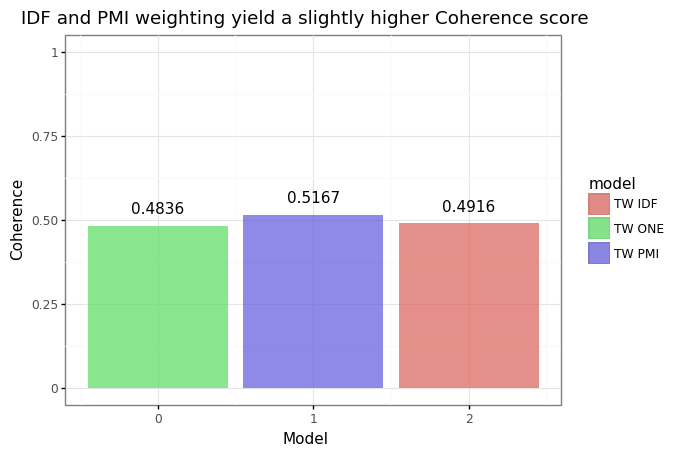

<ggplot: (110064831175)>

In [16]:
# Plotting
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
                    geom_bar, theme, lims, geom_text, position_dodge
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [17]:
hdp_one = tp.HDPModel.load("models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("models/hdp_model_idf.bin")

In [18]:
### All models topics agree with true label

# Infering topics from out of sample text
test_idx = 1

models = [hdp_one, hdp_pmi, hdp_idf]
model_names = df_coherence.model.values
doc_preds = []
test_doc = lemmatized_test[test_idx] # out-of-sample lemmatized test, ex. get 3rd entry in table above


fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.suptitle("True label: " + test_df.topic_name.values[test_idx], size=15)

# Infer MOST LIKELY topic
for i, m in enumerate(models):
    doc_inst = m.make_doc(test_doc)
    topic_dist, ll = m.infer(doc_inst, together=True)
    topic_idx = np.array(topic_dist).argmax()
    
    doc_preds.append((topic_idx, ll))
    
    create_wordcloud(models[i], topic_idx, fig, ax[i])
  
    ax[i].title.set_text("Model " + str(model_names[i]) + ", Topic #" + str(topic_idx))

NameError: name 'lemmatized_test' is not defined